## packages install

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https: // download.pytorch.org / whl / cpu
# !pip install -U matplotlib

## imports

In [1]:
import os
import sys

import numpy as np
from torch import tensor
import torch
from torch.nn import functional
import matplotlib.pyplot as plt
import torchvision

sys.path.append(os.path.abspath(r'../../'))

from src.utils.common import get_model_resnet18_cifar10, get_loader, create_saved_data_dir, get_device, save, load
from src.utils.dataset import get_cifar10
from src.utils.plot import plot_loss_acc, plot_prune_example
from src.utils.train import train, ModelManager, Mode

from src.prune.el2n import get_el2n_scores, get_prune_idx

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
# NUM_VALID = 10000
NUM_TEST = 10000
EPOCHS = 15
EPOCHS_ENSEMBLE = 10
ENSEMBLE_SIZE = 10

DEVICE = get_device()
# PATH_MODELS_SAVE = create_saved_data_dir(os.path.join(os.path.abspath(''), 'research', 'el2n_resnet18_cifar10.ipynb'))

# data loaders, models
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_train, data_test = get_cifar10(os.path.abspath(os.path.join('../../../', 'datasets')))

loader_train = get_loader(data_train, np.arange(NUM_TRAIN), BATCH_SIZE)
# loader_valid = get_loader(data_train, np.arange(NUM_TRAIN, NUM_VALID + NUM_TRAIN), BATCH_SIZE)
loader_test = get_loader(data_test, np.arange(NUM_TEST), BATCH_SIZE)
idx = np.arange(NUM_TRAIN)
# create loader with no shuffling
loader_train_ordered = get_loader(data_train, idx, BATCH_SIZE, shuffle=False)
Y_train = tensor(data_train.targets)[idx]

CUDA is available!  Training on  GPU...
Files already downloaded and verified
Files already downloaded and verified


In [2]:
ensemble: list[ModelManager] = [ModelManager(f'ensemble_{i}', 'el2n') for i in range(ENSEMBLE_SIZE)]
ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)

print()
for i, model_manager in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    model_manager.train(loader_train, loader_test, loader_test, EPOCHS_ENSEMBLE)
    scores, pred, loss, acc = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
    ensemble_softmax[i] =  functional.softmax(scores.clone().detach().cpu(), dim=1)
    ensemble_pred[:, i] = torch.Tensor(pred.type(torch.int8) == Y_train).clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_var = ensemble_softmax.var(dim=0)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)


------------   model 0   -------------------
Epoch: 0 Training: Loss: 0.048158 Acc: 0.573220  Validation Loss: 0.039367 Acc: 0.660100
Validation loss decreased (inf --> 0.039367).  Saving model to models_data/el2n\ensemble_0
Epoch: 1 Training: Loss: 0.030950 Acc: 0.733920  Validation Loss: 0.030380 Acc: 0.737300
Validation loss decreased (0.039367 --> 0.030380).  Saving model to models_data/el2n\ensemble_0
Epoch: 2 Training: Loss: 0.023678 Acc: 0.795540  Validation Loss: 0.024980 Acc: 0.785700
Validation loss decreased (0.030380 --> 0.024980).  Saving model to models_data/el2n\ensemble_0
Epoch: 3 Training: Loss: 0.018147 Acc: 0.842380  Validation Loss: 0.022895 Acc: 0.810600
Validation loss decreased (0.024980 --> 0.022895).  Saving model to models_data/el2n\ensemble_0
Epoch: 4 Training: Loss: 0.013585 Acc: 0.883180  Validation Loss: 0.024202 Acc: 0.804200
Epoch: 5 Training: Loss: 0.009567 Acc: 0.917220  Validation Loss: 0.023924 Acc: 0.818000
Epoch: 6 Training: Loss: 0.006952 Acc: 0.

In [14]:
# path=os.path.abspath(os.path.join(ensemble[0].path_saved_data, '../'))
path = os.path.join(ModelManager.DIR_ROOT, 'models_data', 'el2n', 'general.pt')
torch.save(
    {'ensemble_softmax': ensemble_softmax, 'ensemble_pred': ensemble_pred, 'ensemble_pred_sum': ensemble_pred_sum,
     'ensemble_var': ensemble_var, 'el2n_scores': el2n_scores},
    path)

In [15]:
path = os.path.join(ModelManager.DIR_ROOT, 'models_data', 'el2n', 'general.pt')
data = torch.load(path)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_var = data['ensemble_var']
el2n_scores = data['el2n_scores']

In [16]:
# print(ensemble_softmax[:, 0, :])
# print(ensemble_pred[0])
# print(Y_train[0])
print(el2n_scores[0])
x = el2n_scores[0]
y_hot = torch.nn.functional.one_hot(Y_train[0], num_classes=NUM_CLASSES)
# print(y_hot)
print(((((y_hot - ensemble_softmax[:, 0, :]) ** 2).sum(dim=1)) ** .5).mean())

tensor(0.9341)
tensor(0.9341)


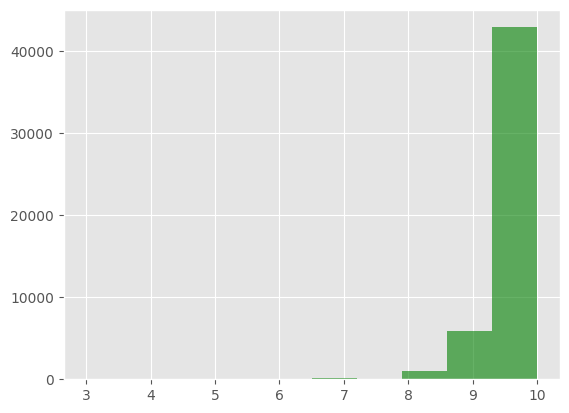

In [12]:
plt.style.use('ggplot')
plt.hist(ensemble_pred_sum, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

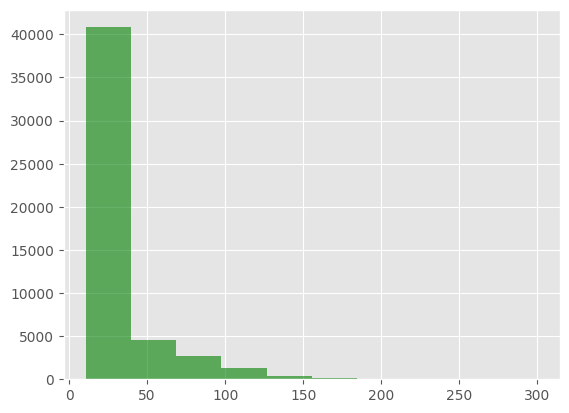

In [13]:
# print(ensemble_var)
# print(ensemble_var.sum(dim=0).shape)
# print(ensemble_var.sum(dim=1).shape)
plt.hist((ensemble_var ** .5).sum(dim=1), facecolor='g', alpha=0.6)
plt.show()

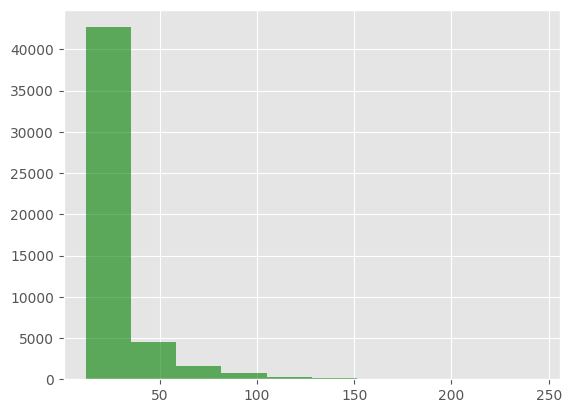

In [7]:
plt.hist(el2n_scores, bins=len(data_train.classes), facecolor='g', alpha=0.6)
plt.show()

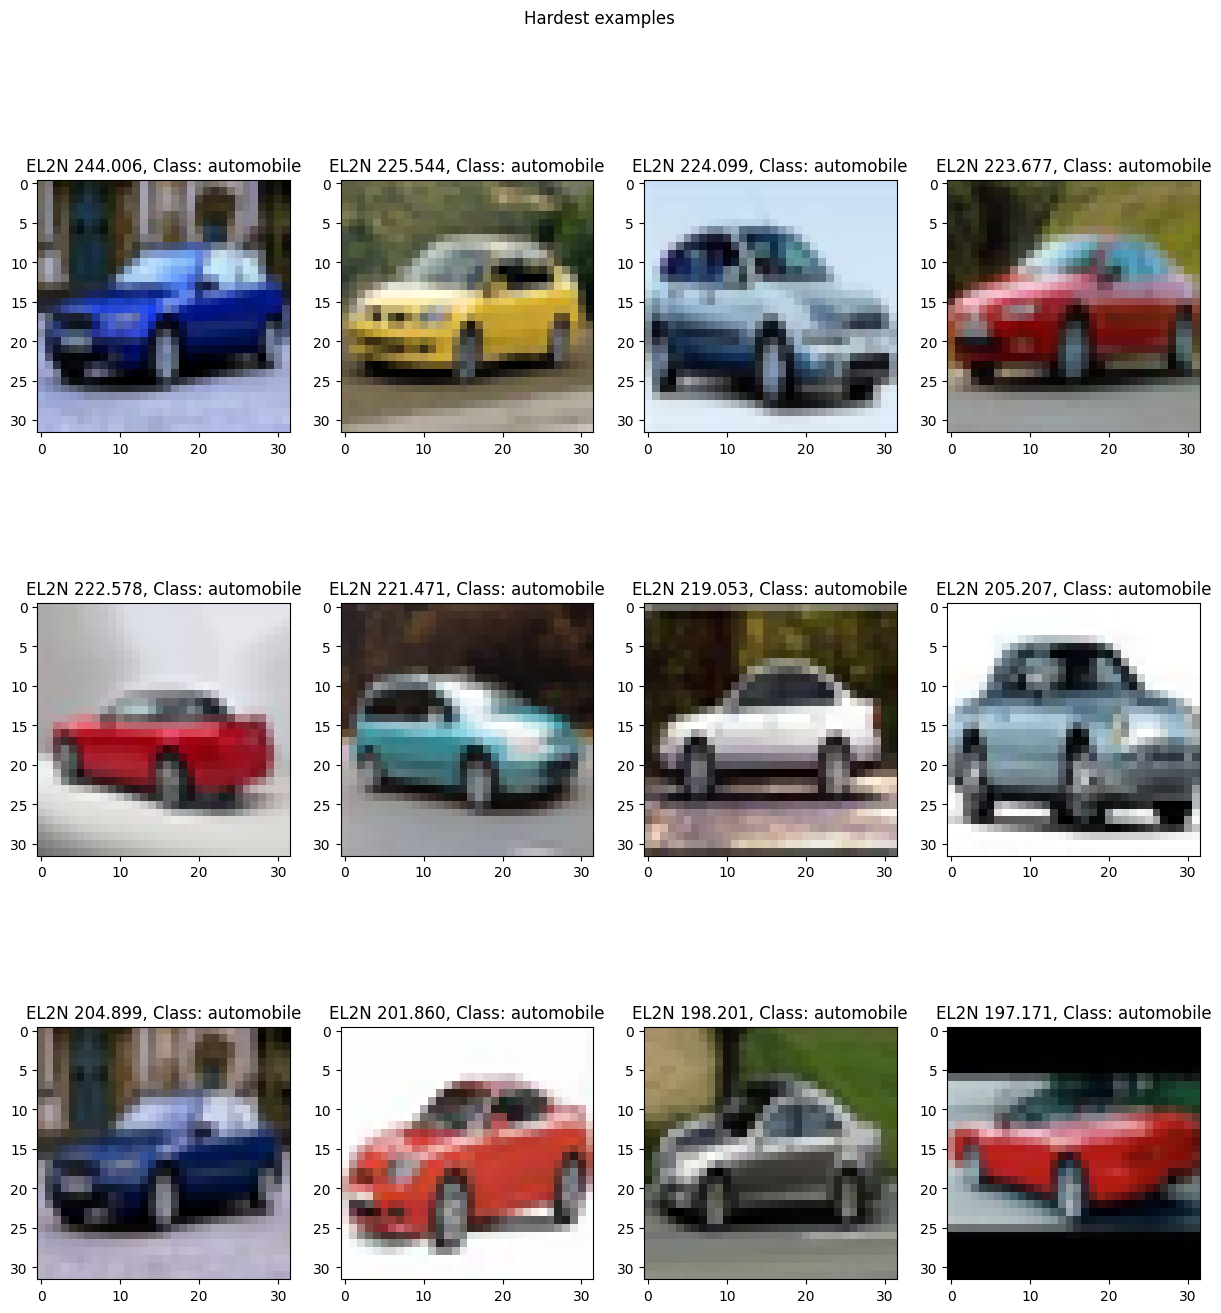

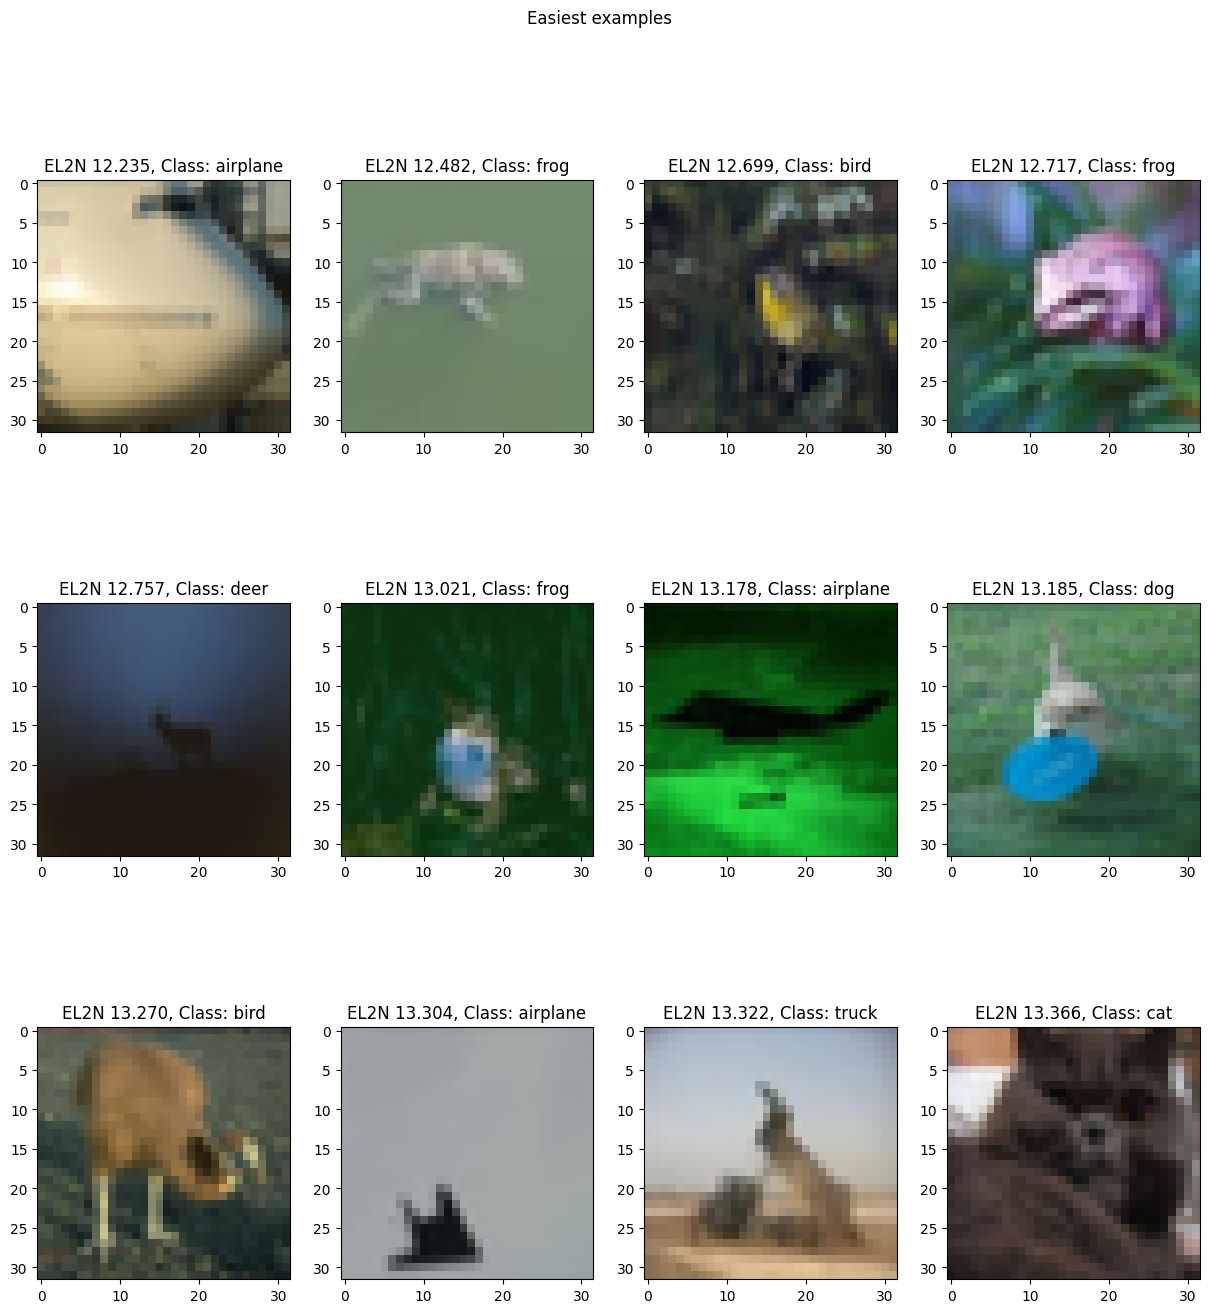

In [5]:
data_train_raw = torchvision.datasets.CIFAR10(os.path.abspath(r'../../../datasets'), train=True)
plot_prune_example(data_train_raw, el2n_scores, hardest=True, prune_method_name='EL2N', random=False)
plot_prune_example(data_train_raw, el2n_scores, hardest=False, prune_method_name='EL2N', random=False)

In [ ]:
# save(PATH_MODELS_SAVE(''),
#      ensemble_pred=ensemble_pred, ensemble_pred_sum=ensemble_pred_sum,
#      ensemble_softmax=ensemble_softmax, ensemble_var=ensemble_var, el2n_scores=el2n_scores
#      )
#
# data = load(PATH_MODELS_SAVE(''))
# ensemble_pred, ensemble_pred_sum = data['ensemble_pred'], data['ensemble_pred_sum']
# ensemble_softmax = data['ensemble_softmax']
# ensemble_var, el2n_scores = data['ensemble_var'], data['el2n_scores']
#
# idx_to_keep = get_prune_idx(Y_train, ensemble_softmax, .8)
#
# # train model with prune
# print("\nrun model with prune")
# loader_train_prune = get_loader(data_train, idx_to_keep, BATCH_SIZE, True)
# model_prune, criterion_prune, optimizer_prune, scheduler_prune = get_model_resnet18_cifar10()
# res_train_prune, res_valid_prune, _ = \
#     train(model_prune, loader_train_prune, loader_test, loader_test, criterion_prune, optimizer_prune,
#           scheduler_prune, EPOCHS, NUM_CLASSES, DEVICE, verbose=True, save_path=PATH_MODELS_SAVE('resnet18_prune'))
# scores_train_prune, pred_train_prune, loss_train_prune, acc_train_prune = res_train_prune
# scores_valid_prune, pred_valid_prune, loss_valid_prune, acc_valid_prune = res_valid_prune
#
# # save data
# save(PATH_MODELS_SAVE(''),
#      idx_to_keep=idx_to_keep, scores_train_prune=scores_train_prune, pred_train_prune=pred_train_prune,
#      loss_train_prune=loss_train_prune, acc_train_prune=acc_train_prune, scores_valid_prune=scores_valid_prune,
#      pred_valid_prune=pred_valid_prune, loss_valid_prune=loss_valid_prune, acc_valid_prune=acc_valid_prune
#      )